In [2]:
!nvidia-smi
!nvcc -V

Mon Oct 23 10:57:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.06       Driver Version: 522.06       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 31%   30C    P8    32W / 320W |   1180MiB / 10240MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
%pip install numpy==1.20.0
%pip install opencv-python
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install ultralytics

  Using cached numpy-1.20.0-cp39-cp39-win_amd64.whl (13.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
  Rolling back uninstall of numpy
  Moving to c:\users\arne\anaconda3\lib\site-packages\numpy-1.24.4.dist-info\
   from C:\Users\Arne\anaconda3\Lib\site-packages\~umpy-1.24.4.dist-info
  Moving to c:\users\arne\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
   from C:\Users\Arne\AppData\Local\Temp\pip-uninstall-hap7wcxb\libopenblas64__v0.3.21-gcc_10_3_0.dll
  Moving to c:\users\arne\anaconda3\lib\site-packages\numpy\__config__.py
   from C:\Users\Arne\AppData\Local\Temp\pip-uninstall-zmu72d5z\__config__.py
  Moving to c:\users\arne\anaconda3\lib\site-packages\numpy\__init__.cython-30.pxd
   from C:\Users\Arne\AppData\Local\Temp\pip-uninstall-zmu72d5z\__init__.cython-30.pxd
  Moving to c:\users\arne\anaconda3\lib\site-packages\numpy\__init__.pxd
 

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Arne\\anaconda3\\Lib\\site-packages\\numpy\\.libs\\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [3]:
import random
import os

import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import torch
print(torch.cuda.is_available())

from ultralytics import YOLO

np.random.seed(42)

True


# Viz image & bounding box
checking if the annotations are correct

In [4]:
IMG_PATH = "./data/train/images/2000w_q95_jpg.rf.157862846e43812237cee9f15ac4466b.jpg"
BB_PATH = "./data/train/labels/2000w_q95_jpg.rf.157862846e43812237cee9f15ac4466b.txt"
DATA_PATH = "E:\\OU\\master\\rm\\pre_shot_sniper_detection\\data\\data.yaml" #must be absolute path

In [90]:
def read_img(img_path:str):
    return cv2.imread(img_path)

In [91]:
def read_bb(bb_file_path:str):
    with open(bb_file_path, "r") as file:
        return file.readlines()

In [92]:
def viz(img_path:str, bb_file_path:str):
    color = [random.randint(0, 255) for _ in range(3)]
    
    img = read_img(img_path)
    bb_info_arr = read_bb(bb_file_path)

    H, W, channels = img.shape
    
    for bb in bb_info_arr:
        bb_coord_arr = bb.split()
        _, x_center, y_center, w, h = bb_coord_arr
        x_center, y_center, w, h = float(x_center), float(y_center), float(w), float(h)
        
        w = float(w*W)
        h = float(h*H)

        x = float(x_center*W - (w/2))
        y = float(y_center*H - (h/2))

        x1 = round(x)
        y1 = round(y)
        x2 = round(x+w)
        y2 = round(y+h)
        
        cv2.rectangle(img, (x1,y1), (x2,y2), color, cv2.LINE_4)
        cv2.circle(img, (round(x_center*W), round(y_center*H)), radius=0, color=(255,0,0), thickness=0)
    plt.imshow(img)

Width:  640
Height:  640
182 309 336 361
453 328 635 392
237 237 321 275


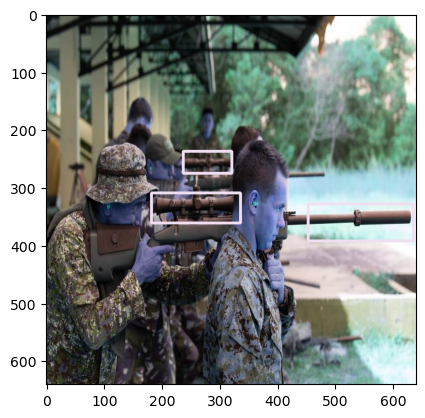

In [93]:
viz(IMG_PATH, BB_PATH)

# Image Selection

In [5]:
def remove_cache():
    for directory in ["train", "test", "valid"]:
        path = f"./data/{directory}/labels.cache"
        if os.path.isfile(path):
            os.remove(path)

In [6]:
def select_imgs(num_imgs:int):
    remove_cache()
    
    num_train = int(num_imgs *0.8)
    num_val = int(num_imgs *0.1)
    num_test = int(num_imgs *0.1)
    
    img_path = "./data/raw/images/"
    bb_path = "./data/raw/labels/"
    
    files = os.listdir(img_path)[:num_imgs]

    
    for file in files[:num_train]:
        img_file = file[:-3]+"jpg" 
        bb_file = file[:-3]+"txt"
        
        shutil.copy(img_path+img_file, f"./data/train/images/{img_file}")
        shutil.copy(bb_path+bb_file, f"./data/train/labels/{bb_file}")
        
    for file in files[num_train:num_train+num_val]:
        img_file = file[:-3]+"jpg" 
        bb_file = file[:-3]+"txt"
        
        shutil.copy(img_path+img_file, f"./data/valid/images/{img_file}")
        shutil.copy(bb_path+bb_file, f"./data/valid/labels/{bb_file}")
    
    for file in files[num_train+num_val:]:
        img_file = file[:-3]+"jpg" 
        bb_file = file[:-3]+"txt"
        
        shutil.copy(img_path+img_file, f"./data/test/images/{img_file}")
        shutil.copy(bb_path+bb_file, f"./data/test/labels/{bb_file}")

# Train & validate the model

In [7]:
def train(name:str):
    model = YOLO("./yolov8n.pt")
    model.train(data=DATA_PATH, epochs=100, imgsz=640, name=name, device=0)
    metrics = model.val(name=name+"_val") #conf is 0.001
    print('-'*20)
    print(metrics)
    print('-'*20)

In [8]:
for img_num in [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]:
    train(str(img_num) +"_imgs")

Ultralytics YOLOv8.0.200  Python-3.9.18 torch-2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10239MiB)
engine\trainer: task=detect, mode=train, model=./yolov8n.pt, data=E:\OU\master\rm\pre_shot_sniper_detection\data\data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=100_imgs2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, bo

--------------------
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001D84BFB4E80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047

Ultralytics YOLOv8.0.200  Python-3.9.18 torch-2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10239MiB)
engine\trainer: task=detect, mode=train, model=./yolov8n.pt, data=E:\OU\master\rm\pre_shot_sniper_detection\data\data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=150_imgs, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, box